In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
from collections import defaultdict
from scipy.signal import savgol_filter, savgol_coeffs

In [2]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor <= 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5, polyorder=3):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = polyorder
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

In [3]:
# load data and store into lists
import os
import pandas as pd
import re


file_path = "../data/USANS/28523/"
sample_files = [f for f in os.listdir(file_path)]# if 'UN' in f.lower()]
labels = ["unscaled", "lb.", "lbs"]
filtered_files = [f for f in sample_files if labels[1] in f]
# Prepare lists to store extracted info
measure_times = []
samples = []

for idx, filename in enumerate(filtered_files):
    print(f"Index: {idx}, Filename: {filename}")

for fname in filtered_files:
    # Extract measure time (e.g., 1e4, 3e5, etc.)
    match_time = re.search(r'_(\d+e\d+)_', fname)
    measure_times.append(match_time.group(1) if match_time else None)
    # Extract samples (e.g., Sample1, Sample2, etc.)
    match_samples = re.search(r'(Sample\d+)', fname, re.IGNORECASE)
    samples.append(match_samples.group(1) if match_samples else None)

samples = [
    np.loadtxt(os.path.join(file_path, fname), skiprows=0, delimiter=',', usecols=(0,1,2))
    for fname in filtered_files
]



Index: 0, Filename: UN_DPPC0.2h-HA10_det_1_lb.txt
Index: 1, Filename: UN_h-HA_5_det_1_lb.txt
Index: 2, Filename: UN_DPPC0.2h-HA5_det_1_lb.txt
Index: 3, Filename: UN_DPPC1.2l-HA1.5_det_1_lb.txt
Index: 4, Filename: UN_DPPC0.2l-HA4_det_1_lb.txt
Index: 5, Filename: UN_h-HA_3_det_1_lb.txt
Index: 6, Filename: UN_DPPC0.2l-HA0.33_det_1_lb.txt
Index: 7, Filename: UN_DPPC0.2h-HA1.5_det_1_lb.txt
Index: 8, Filename: UN_l-HA_1.5_det_1_lb.txt
Index: 9, Filename: UN_h-HA_10_det_1_lb.txt
Index: 10, Filename: UN_DPPC1.2h-HA2_det_1_lb.txt
Index: 11, Filename: UN_DPPC_5_det_1_lb.txt


116


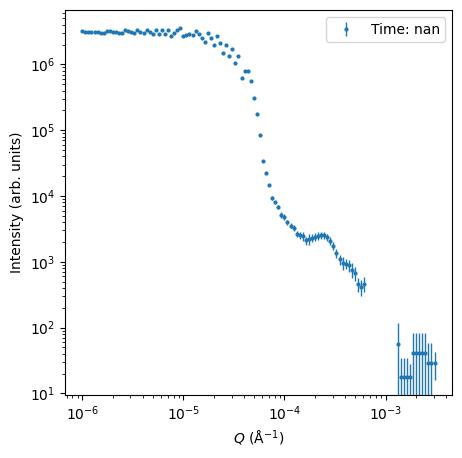

In [4]:
# display the line profile to be used to produce the counts

data = defaultdict(lambda: defaultdict(dict))  # data[bin][collimation][time]
# For USANS, we use bin='USANS' and collimation='-', time is represented by total counts

# Store sample data into the data structure using measurement time as key
for i, arr in enumerate([samples[0]]):
    Q = arr[:, 0]
    I = arr[:, 1]
    I_err = arr[:, 2]
    dQ = np.zeros_like(Q)  # USANS files may not have dQ; set to zeros or estimate if available
    total_counts = 'nan'
    # Use bin='USANS', collimation='-', time=str(int(total_counts))
    data['USANS']['-'][total_counts] = ScatteringData(Q, I, I_err, dQ, total_counts=total_counts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

collimation = '-'  # USANS uses '-' for collimation
sorted_time_keys = sorted(data['USANS'][collimation].keys(), key=lambda x: float(x))
for i_time, time_key in enumerate(sorted_time_keys):
    scattering_data = data['USANS'][collimation][time_key]
    Q = scattering_data.Q
    I = scattering_data.I
    I_err = scattering_data.I_err
    dQ = scattering_data.dQ
    total_counts = scattering_data.total_counts

    ax.errorbar(Q, I, yerr=I_err, label=f'Time: {time_key}', fmt='o', markersize=2, elinewidth=1)
    print(len(Q))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$Q$ ($\mathrm{\AA}^{-1}$)')
ax.set_ylabel(r'Intensity (arb. units)')
ax.legend()

Using best dataset: Bin size = USANS, Time = nan
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synthetic data generation
Using nbins = 297 for USANS synth

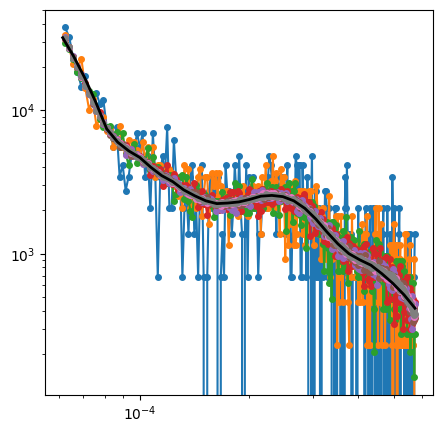

In [5]:
# Select a collimation to analyze
fixed_collimation = '-'  # manually selected

best_bin_size_str = 'USANS'  # manually selected
best_time_str = 'nan'
best_data = data[best_bin_size_str][fixed_collimation][best_time_str]

print(f"Using best dataset: Bin size = {best_bin_size_str}, Time = {best_time_str}")

# select the Q range of interest
Q_min_range = 6e-5
Q_max_range = 6e-4

Q_mask = (best_data.Q >= Q_min_range) & (best_data.Q <= Q_max_range)
best_data = ScatteringData(best_data.Q[Q_mask], best_data.I[Q_mask], best_data.I_err[Q_mask], best_data.dQ[Q_mask])

# L is the range between min and max Q of the best data
L = best_data.Q.max() - best_data.Q.min()
Qmin, Qmax = np.min(best_data.Q), np.max(best_data.Q)

# --- Synthetic dataset generation parameters ---
samples_per_bin = 16  # quadrature samples per bin for averaging, manually selected
synthetic_data = defaultdict(lambda: defaultdict(dict))  # [bin][collimation][time_str] -> ScatteringData

count_list = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6]  # total counts for USANS synthetic data

# Synthetic datasets for each bin size and time ---
# this loop produces synthetic datasets: synthetic_data_list
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

N_MC = 32
synthetic_data_list = []
for i_MC in range(N_MC):
    synthetic_data_list.append(defaultdict(lambda: defaultdict(dict)))
    # for bin_size_key_int in sorted_bin_size_keys:
    # USANS only has one "bin size"
    bin_size_key = 'USANS'
    # Reference: number of bins from real dataset at this bin size
    sd_ref = best_data
    nbins = int(len(sd_ref.Q)*9)
    print(f"Using nbins = {nbins} for USANS synthetic data generation")

    # Uniform bin geometry over [Qmin, Qmax], avoiding edges
    bin_width = L / nbins
    Q_centers = np.linspace(Qmin + 0.5 * bin_width, Qmax - 0.5 * bin_width, nbins)
    dQ_uniform = np.full(nbins, bin_width)

    for i_time, total_counts in enumerate(count_list):

        # Compute mean intensity in each bin using ground truth
        I_mean_uniform = np.empty(nbins, dtype=float)
        for i, Qc in enumerate(Q_centers):
            QL = Qc - 0.5 * bin_width
            QR = Qc + 0.5 * bin_width
            qgrid = np.linspace(QL, QR, samples_per_bin)
            I_vals = interpolate_best_I(best_data, qgrid, window_length=9, polyorder=3)
            I_mean_uniform[i] = np.trapz(I_vals, qgrid) / bin_width 

        # Distribute total counts proportionally to mean intensity in each bin
        I_sum = np.sum(I_mean_uniform)
        if I_sum > 0:
            counts_uniform = total_counts * (I_mean_uniform / I_sum)
        else:
            counts_uniform = np.full(nbins, total_counts / nbins)

        # Counting error per bin: ΔI = I / sqrt(N_bin)
        I_err_uniform = I_mean_uniform / np.sqrt(counts_uniform)
        
        rng = np.random.default_rng()
        # Sample I values from a Gaussian for each bin (mean=I_mean_uniform, std=I_err_uniform)
        I_uniform = rng.normal(loc=I_mean_uniform, scale=I_err_uniform)

        # Sample I values from Poisson for each bin (mean=counts_uniform), then scale by I_mean_uniform / counts_uniform
        counts_sampled = rng.poisson(lam=counts_uniform)
        I_uniform = I_mean_uniform * (counts_sampled / counts_uniform)

        # Pack into ScatteringData and store
        sd_syn = ScatteringData(Q_centers, I_uniform, I_err_uniform, dQ_uniform)
        sd_syn.total_counts = float(total_counts)
        synthetic_data = synthetic_data_list[i_MC]
        synthetic_data[bin_size_key][collimation][total_counts] = sd_syn

        # Plot only for the first bin size
        if bin_size_key == 'USANS' and i_MC == 0:
            ax.loglog(Q_centers, I_uniform, label=f'Bin: {bin_size_key}, Time: {total_counts}', linestyle='-', marker='o', markersize=4)

# best - smoothed ground truth for evaluation of probability
ax.loglog(best_data.Q, interpolate_best_I(best_data, best_data.Q, window_length=9, polyorder=2), label='Best Data (Ground Truth)', color='black', marker='', linestyle='-', linewidth=2)
print("bin width:", bin_width)

In [6]:
def calculate_slope_integral(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_slope_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=1
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=1, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_prime = D @ I
    I_prime_sq = I_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def calculate_curvature_integral(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I
    
    # Use Savitzky-Golay filter to get the second derivative of intensity with respect to Q
    smoothed_I_double_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=2, delta=np.mean(np.diff(Q_best)))
    
    # Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_curvature_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=2
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=2, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_double_prime = D @ I
    I_double_prime_sq = I_double_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_double_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_double_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def f_beta(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the beta parameter 
    """
    beta = calculate_slope_integral(data, window_length, polyorder) / (12.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_slope_integral_with_uncertainty(data, window_length, polyorder)
        beta, beta_std = integral / (12.0 * (data.Q.max() - data.Q.min())), integral_std / (12.0 * (data.Q.max() - data.Q.min()))
        return beta, beta_std
    return beta

def f_gamma(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the gamma parameter 
    """
    gamma = calculate_curvature_integral(data, window_length, polyorder) / (4.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_curvature_integral_with_uncertainty(data, window_length, polyorder)
        gamma, gamma_std = integral / (4.0 * (data.Q.max() - data.Q.min())), integral_std / (4.0 * (data.Q.max() - data.Q.min()))
        return gamma, gamma_std
    return gamma

def f_alpha(data, total_counts):
    """
    Calculate the A0 parameter 
    """
    L = data.Q.max() - data.Q.min()
    mean_I = np.mean(data.I)
    return L * (mean_I ** 2)/ total_counts

Bin Size: USANS, Time: 1000.0
  alpha: Mean = 2.760289e+00, Std = 1.490519e-01
  beta: Mean = 6.971969e+15, Std = 2.204036e+15
  gamma: Mean = 1.441199e+26, Std = 6.313255e+25
  h_FD: Mean = 5.948019e-06, Std = 6.148534e-07
  lambda: Mean = 4.309076e-06, Std = 3.400994e-07
  chi: Mean = 1.125488e+00, Std = 1.872969e-01
Bin Size: USANS, Time: 3000.0
  alpha: Mean = 9.177166e-01, Std = 2.527719e-02
  beta: Mean = 6.574151e+15, Std = 1.095054e+15
  gamma: Mean = 1.105622e+26, Std = 2.887772e+25
  h_FD: Mean = 4.143208e-06, Std = 2.360224e-07
  lambda: Mean = 3.607403e-06, Std = 1.967587e-07
  chi: Mean = 4.486889e-01, Std = 3.696045e-02
Bin Size: USANS, Time: 10000.0
  alpha: Mean = 2.721950e-01, Std = 5.921451e-03
  beta: Mean = 6.088835e+15, Std = 6.116741e+14
  gamma: Mean = 9.258775e+25, Std = 1.482683e+25
  h_FD: Mean = 2.822831e-06, Std = 8.803879e-08
  lambda: Mean = 2.914981e-06, Std = 9.049445e-08
  chi: Mean = 1.909560e-01, Std = 1.056061e-02
Bin Size: USANS, Time: 30000.0
  alp

/tmp/ipykernel_1277464/892448374.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


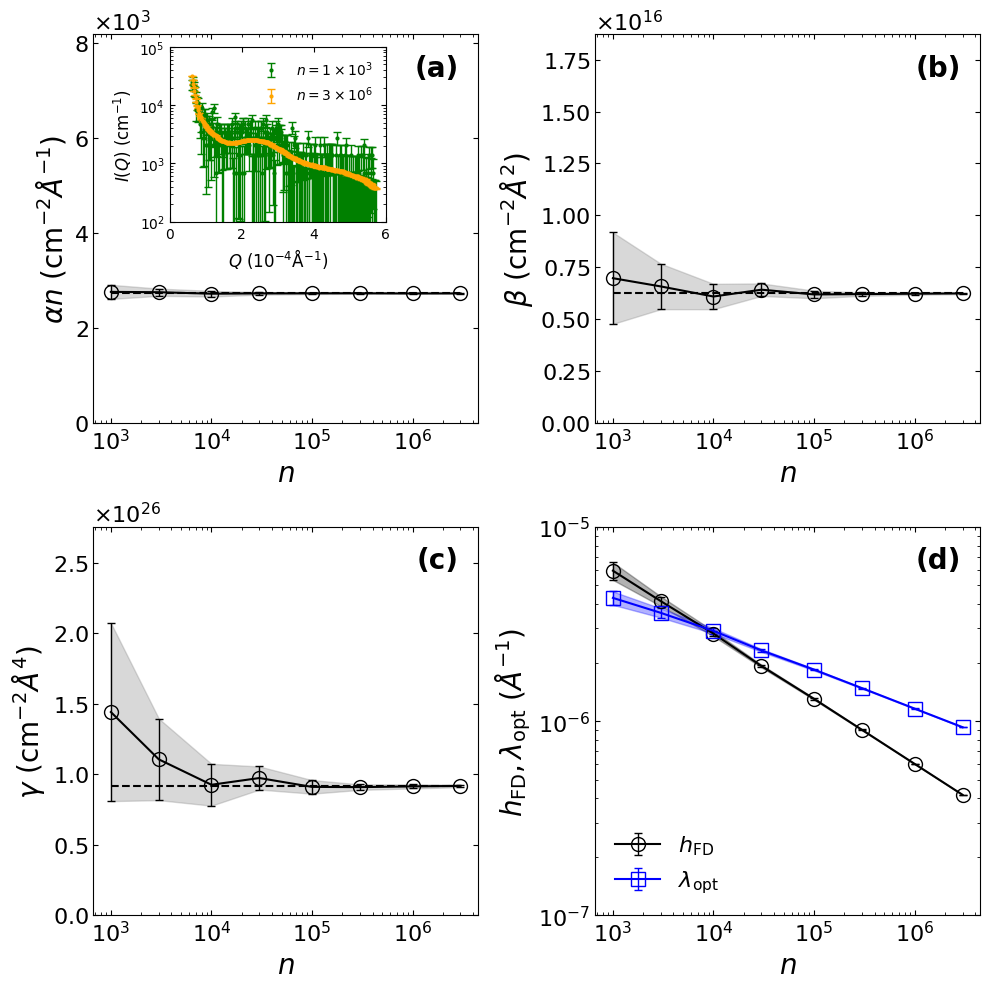

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# convergence test
# for each synthetic dataset, calculate the integral parameters and structural lengthscale
# Initialize results to store parameters for each bin size and time key
results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for i_MC in range(N_MC):
    synthetic_data = synthetic_data_list[i_MC]
    for bin_size_key in synthetic_data.keys():
        for time_key in synthetic_data[bin_size_key][collimation].keys():
            sd_syn = synthetic_data[bin_size_key][collimation][time_key]
            alpha_syn = f_alpha(sd_syn, total_counts=sd_syn.total_counts)
            beta_syn = f_beta(sd_syn, window_length=15, polyorder=2)
            gamma_syn = f_gamma(sd_syn, window_length=15, polyorder=2)
            # beta_syn, beta_syn_std = f_beta(sd_syn, window_length=7, polyorder=3, std=True)
            # gamma_syn, gamma_syn_std = f_gamma(sd_syn, window_length=7, polyorder=3, std=True)
            # Calculate h_FD for the synthetic dataset
            h_FD_syn = (alpha_syn / (2 * beta_syn))**(1/3)
            chi_syn = (gamma_syn / beta_syn) * (alpha_syn / beta_syn)**(2/3)
            lambda_syn = (alpha_syn / (8 * np.sqrt(np.pi) * gamma_syn))**(1/5)
            results[bin_size_key][time_key]['alpha'].append(alpha_syn)
            results[bin_size_key][time_key]['beta'].append(beta_syn)
            # results[bin_size_key][time_key]['beta_std'].append(beta_syn_std)
            results[bin_size_key][time_key]['gamma'].append(gamma_syn)
            # results[bin_size_key][time_key]['gamma_std'].append(gamma_syn_std)
            results[bin_size_key][time_key]['h_FD'].append(h_FD_syn)
            results[bin_size_key][time_key]['lambda'].append(lambda_syn)
            results[bin_size_key][time_key]['chi'].append(chi_syn)

stats = defaultdict(lambda: defaultdict(dict))
# Calculate mean and std for each time_key
for bin_size_key in results.keys():
    for time_key in results[bin_size_key].keys():
        for param in results[bin_size_key][time_key].keys():
            values = np.array(results[bin_size_key][time_key][param])
            mean_val = np.mean(values)
            std_val = np.std(values)
            stats[bin_size_key][time_key][param] = {'mean': mean_val, 'std': std_val}
            
# Display results
for bin_size_key in stats.keys():
    for time_key in stats[bin_size_key].keys():
        print(f"Bin Size: {bin_size_key}, Time: {time_key}")
        for param in stats[bin_size_key][time_key].keys():
            mean_val = stats[bin_size_key][time_key][param]['mean']
            std_val = stats[bin_size_key][time_key][param]['std']
            print(f"  {param}: Mean = {mean_val:.6e}, Std = {std_val:.6e}")
            
# plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
index_param = 'alpha'
for time_key in count_list:
    stat_mean = np.array([stats['USANS'][time_key][index_param]['mean'] for time_key in count_list])
    stat_std = np.array([stats['USANS'][time_key][index_param]['std'] for time_key in count_list])
y_lt = (stat_mean * np.array(count_list))[-1]
# Plot the mean with error bars
# ax.plot(count_list, stat_mean*np.array(count_list), label=f'{index_param} mean', marker='o', color='k', markersize=10, fillstyle='none')
ax.errorbar(count_list, stat_mean * np.array(count_list), yerr=stat_std * np.array(count_list), fmt='', elinewidth=1, label=f'{index_param} std', marker='o', color='k', capsize=3, markersize=10, fillstyle='none')
# Add confidence interval as filled area
lower_bound = (stat_mean - stat_std) * np.array(count_list)
upper_bound = (stat_mean + stat_std) * np.array(count_list)
ax.fill_between(count_list, lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')
ax.hlines(y=y_lt, xmin=count_list[0], xmax=count_list[-1], color='k', linestyles='dashed')

ax.set_xscale('log')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\alpha n\ (\mathrm{cm}^{-2}\AA^{-1})$', fontsize=20)
# ax.set_ylim(5e3, 1e4)

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_y(1.02)
ax.set_ylim(y_lt*0, y_lt*3)
ax.text(0.95, 0.95, '(a)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
# ax.legend()        

syn_short_time = synthetic_data['USANS']['-'][count_list[0]]
syn_long_time = synthetic_data['USANS']['-'][count_list[-1]]

# Add inset plot for a zoomed-in view of the last subplot

inset_ax = inset_axes(ax, width="56.25%", height="45%", loc='lower left', bbox_to_anchor=(0.18, 0.5, 1, 1), bbox_transform=ax.transAxes)
inset_ax.errorbar(syn_short_time.Q, syn_short_time.I, yerr=syn_short_time.I_err, fmt='o', markersize=2, elinewidth=1, label=f'$n={np.ceil(count_list[0]/10**(np.floor(np.log10(count_list[0])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[0])).astype(int)}$', color='green', capsize=3)
inset_ax.errorbar(syn_long_time.Q, syn_long_time.I, yerr=syn_long_time.I_err, fmt='o', markersize=2, elinewidth=1, label=f'$n={np.ceil(count_list[-1]/10**(np.floor(np.log10(count_list[-1])))).astype(int)}\\times 10^{np.floor(np.log10(count_list[-1])).astype(int)}$', color='orange', capsize=3)
# inset_ax.set_xscale('log')
inset_ax.set_yscale('log')
inset_ax.set_xlim(0, 6e-4)
inset_ax.set_ylim(1e2, 1e5)
inset_ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
inset_ax.set_xticklabels(['0', '2', '4', '6'])
inset_ax.set_xlabel(r'$Q$ ($10^{-4}\mathrm{\AA}^{-1}$)', fontsize=12)
inset_ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=12)
inset_ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=10)
inset_ax.legend(fontsize=10, frameon=False)

ax = fig.add_subplot(222)
index_param = 'beta'
index_std = 'beta_std'
for time_key in count_list:
    stat_mean = np.array([stats['USANS'][time_key][index_param]['mean'] for time_key in count_list])
    stat_std = np.array([stats['USANS'][time_key][index_param]['std'] for time_key in count_list])
y_lt = stat_mean[-1]
# Plot the mean with error bars
# ax.plot(count_list, stat_mean, label=f'{index_param} mean', marker='o', color='k', markersize=10, fillstyle='none')
ax.errorbar(count_list, stat_mean, yerr=stat_std, fmt='', elinewidth=1, label=f'{index_param} std', marker='o', color='k', capsize=3, markersize=10, fillstyle='none')
lower_bound = stat_mean - stat_std
upper_bound = stat_mean + stat_std
# Add confidence interval as filled area
ax.fill_between(count_list, stat_mean - stat_std, stat_mean + stat_std, color='gray', alpha=0.3, label='Confidence Interval')
ax.hlines(y=y_lt, xmin=count_list[0], xmax=count_list[-1], color='k', linestyles='dashed')

# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\beta\ (\mathrm{cm}^{-2}\AA^{2})$', fontsize=20)
# ax.set_ylim(2.5e17, 5e17)

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_y(1.02)
ax.set_ylim(y_lt*0, y_lt*3)
ax.text(0.95, 0.95, '(b)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
# ax.legend()   

ax = fig.add_subplot(223)
index_param = 'gamma'
index_std = 'gamma_std'
for time_key in count_list:
    stat_mean = np.array([stats['USANS'][time_key][index_param]['mean'] for time_key in count_list])
    stat_std = np.array([stats['USANS'][time_key][index_param]['std'] for time_key in count_list])
y_lt = stat_mean[-1]

# Plot the mean with error bars
# ax.plot(count_list, stat_mean, label=f'{index_param} mean', marker='o', color='k', markersize=10, fillstyle='none')
ax.errorbar(count_list, stat_mean, yerr=stat_std, fmt='', elinewidth=1, label=f'{index_param} std', marker='o', color='k', capsize=3, markersize=10, fillstyle='none')
lower_bound = stat_mean - stat_std
upper_bound = stat_mean + stat_std
# Add confidence interval as filled area
ax.fill_between(count_list, stat_mean - stat_std, stat_mean + stat_std, color='gray', alpha=0.3, label='Confidence Interval')
ax.hlines(y=y_lt, xmin=count_list[0], xmax=count_list[-1], color='k', linestyles='dashed')

# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$\gamma\ (\mathrm{cm}^{-2}\AA^{4})$', fontsize=20)

ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_y(1.02)
ax.set_ylim(y_lt*0, y_lt*3)
ax.text(0.95, 0.95, '(c)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
# ax.legend(frameon=False, fontsize=16, loc='lower right')

ax = fig.add_subplot(224)
index_param = 'h_FD'
for time_key in count_list:
    stat_mean = np.array([stats['USANS'][time_key][index_param]['mean'] for time_key in count_list])
    stat_std = np.array([stats['USANS'][time_key][index_param]['std'] for time_key in count_list])
# ax.plot(count_list, stat_mean, label=f'{index_param} mean', marker='o', color='k', markersize=10)
ax.errorbar(count_list, stat_mean, yerr=stat_std, fmt='', elinewidth=1, label=r'$h_\mathrm{FD}$', marker='o', color='k', capsize=3, markersize=10, fillstyle='none')
ax.fill_between(count_list, stat_mean - stat_std, stat_mean + stat_std, color='k', alpha=0.3)
index_param = 'lambda'
for time_key in count_list:
    stat_mean = np.array([stats['USANS'][time_key][index_param]['mean'] for time_key in count_list])
    stat_std = np.array([stats['USANS'][time_key][index_param]['std'] for time_key in count_list])
# ax.plot(count_list, stat_mean, label=f'$\lambda_\mathrm{{opt}}$', marker='s', color='b', fillstyle='none', markersize=10)
ax.errorbar(count_list, stat_mean, yerr=stat_std, fmt='', elinewidth=1, label=r'$\lambda_\mathrm{opt}$', marker='s', color='b', capsize=3, markersize=10, fillstyle='none')
ax.fill_between(count_list, stat_mean - stat_std, stat_mean + stat_std, color='b', alpha=0.3)
h_instr = bin_width
# ax.axhline(h_instr, color='r', linestyle='--', label=r'$h_\mathrm{instr}$')
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$n$', fontsize=20)
ax.set_ylabel(r'$h_\mathrm{FD}, \lambda_\mathrm{opt}\ (\AA^{-1})$', fontsize=20)
ax.set_ylim(1e-7, 1e-5)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
ax.legend(frameon=False, fontsize=16, loc='lower left')
ax.text(0.95, 0.95, '(d)', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()

In [10]:
synthetic_data['USANS']['-']

{1000.0: <__main__.ScatteringData at 0x7fe8e8fdb340>,
 3000.0: <__main__.ScatteringData at 0x7fe8e8ff0c10>,
 10000.0: <__main__.ScatteringData at 0x7fe8e8ff0c70>,
 30000.0: <__main__.ScatteringData at 0x7fe8e8ff0cd0>,
 100000.0: <__main__.ScatteringData at 0x7fe8e8ff0d30>,
 300000.0: <__main__.ScatteringData at 0x7fe8e8ff05e0>,
 1000000.0: <__main__.ScatteringData at 0x7fe8e8ff0df0>,
 3000000.0: <__main__.ScatteringData at 0x7fe8e8ff0e80>}